In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings
import h5py

/home1/08942/nianyic/anaconda3/lib/python3.9/site-packages/scipy/stats/_ksstats.py:74: RuntimeWarning: invalid value encountered in ldexp
  _EP128 = np.ldexp(np.longdouble(1), _E128)


In [3]:
outdir = '/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind'
pig2 = BigFile(outdir)
pig = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind')


# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [4]:
Length = pig2['FOFGroups/LengthByType']
Offset = pig2['FOFGroups/OffsetByType']

gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

In [42]:
# last = 83556320
# size = sLength.size - last
# data = sOffset[last][None,:] * np.ones((size, 6), dtype=np.int64)

# sOffset.write(last, data)

## compute offset using goff and slen

(7, 6) (6,)
[1.57884591e+10 1.68547516e+10 0.00000000e+00 0.00000000e+00
 5.99322369e+09 3.55806800e+06] [1.57884623e+10 1.68547549e+10 0.00000000e+00 0.00000000e+00
 5.99322392e+09 3.55806900e+06]


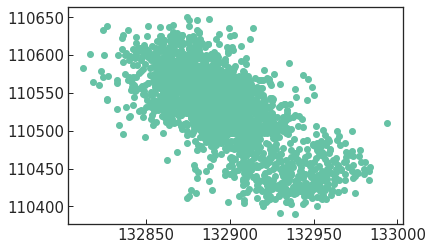

[1.57884623e+10 1.68547549e+10 0.00000000e+00 0.00000000e+00
 5.99322392e+09 3.55806900e+06] [1.57884631e+10 1.68547559e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06]


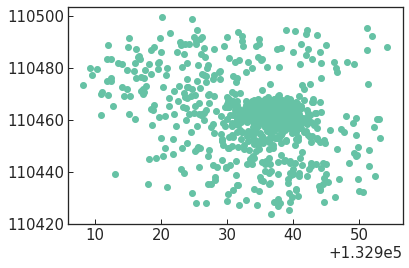

[1.57884631e+10 1.68547559e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06] [1.57884633e+10 1.68547561e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06]


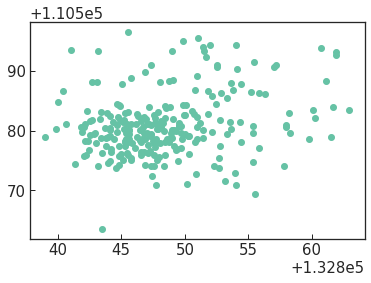

[1.57884633e+10 1.68547561e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06] [1.57884634e+10 1.68547562e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06]


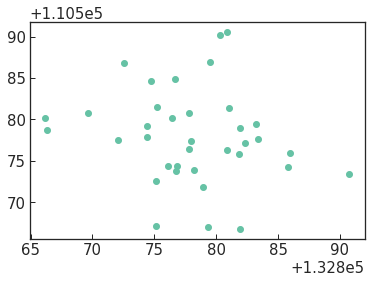

[1.57884634e+10 1.68547562e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06] [1.57884634e+10 1.68547562e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06]


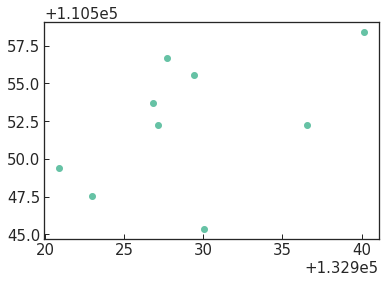

[1.57884634e+10 1.68547562e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06] [1.57884634e+10 1.68547562e+10 0.00000000e+00 0.00000000e+00
 5.99322399e+09 3.55807000e+06]


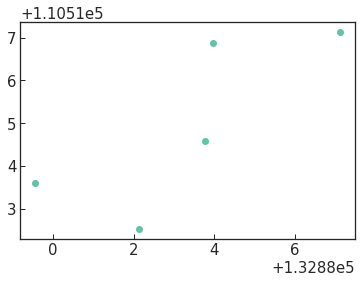

In [63]:
gg = 1000400
first = FirstSub[gg]
nsub = NSubs[gg]

slen = sLength[first:first+nsub]
soff = np.cumsum(slen, axis=0)
soff = np.concatenate([np.zeros((1,6), dtype=int), soff], axis=0)
goff = Offset[gg]
print(soff.shape, goff.shape)
for sidx in range(0, nsub):
    start, end = goff + soff[sidx], goff + soff[sidx] + slen[sidx]
    print(start, end)
    start = start.astype(int)
    end = end.astype(int)
    pos = pig2['0/Position'][start[0]: end[0]]
    plt.scatter(pos[:,0], pos[:,1])
    plt.show()

### check the soff column

In [4]:
mass4 = sMass[:][:,4]*1e10/hh

In [5]:
mask = mass4 > 1e8

In [10]:
sidxlist = np.arange(len(mass4))[mask]
sidx = sidxlist[90200]

start,end = sOffset[sidx], sOffset[sidx] + sLength[sidx]
pos = pig2['4/Position'][start[4]: end[4]]

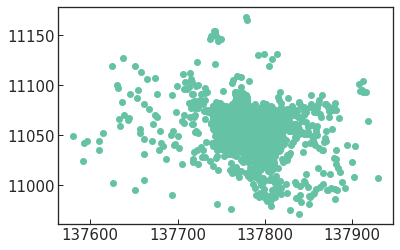

In [11]:
plt.scatter(pos[:,0], pos[:,1])

In [5]:
subroot = '/hildafs/datasets/Asterix//subfind/subfind_348'
tab="fof_subhalo_tab_348.hdf5"
grp = "snap-groupordered_348.hdf5"

In [6]:
def get_subfind_chunk(subroot):
    subdir = subroot + '/*'
    
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    return chunk_list, maxgroup_list 

In [6]:
chunk_list, maxgroup_list = get_subfind_chunk(subroot)
len(chunk_list)
chunks = chunk_list

In [9]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 1e6)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

819576


In [9]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:]
suboff4 = suboff[:,4]
del suboff

In [12]:
si = suboff4[10000000]
si

-2147483648

In [11]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:54000000][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [12]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


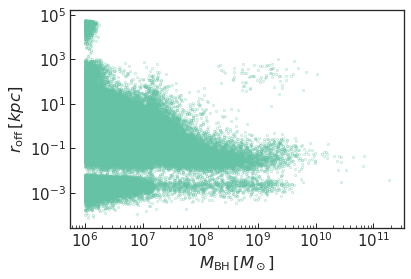

In [13]:
plt.scatter(bmass,roff/3,s=0.1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.ylabel(r'$r_{\rm off}\,[kpc]$')
plt.yscale('log')

## corner case 1: very small offsets

These are cases where the minpot pos is exactly the BH particle?

In [27]:
mask1 = roff < 1e-3
sidxlist1 = sidxlist[mask1]
bidxlist1 = bidxlist[mask1]
print(len(sidxlist1))
# print(sidxlist1)

157


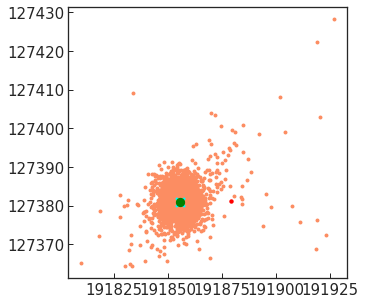

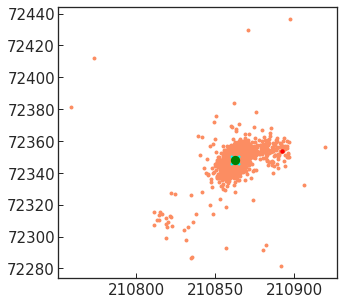

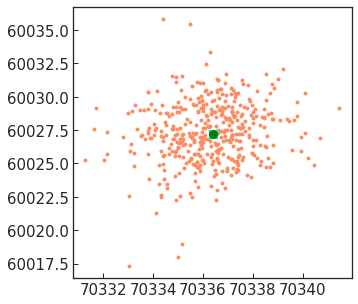

In [28]:
for bidx,sidx in zip(bidxlist1[40:43],sidxlist1[40:43]):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)
    # dpos = pig2['1/Position'][sstart[1]:send[1]] 
    # gpos = pig2['0/Position'][sstart[0]:send[0]] 
    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
#     print(pig2['5/SubgroupID'][sstart[5]:send[5]])
    
#     print(bpos)
    target = pig2['5/Position'][bidx] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    # print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')

    # ax.scatter(dpos[:,0],dpos[:,1],s=2,color='k')
    # ax.scatter(gpos[:,0],gpos[:,1],s=3,color='b')
    ax.scatter(spos[:,0],spos[:,1],s=3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax.scatter(target[0],target[1],s=50,color='green')

    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    # ax.set(xticklabels=[],yticklabels=[])
    plt.show()

###

## individual group comparisons

In [ ]:
p = 4
for sidx in range(400,410):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)
    dpos = pig2['1/Position'][sstart[1]:send[1]] 
    gpos = pig2['0/Position'][sstart[0]:send[0]] 
    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
    print(pig2['5/SubgroupID'][sstart[5]:send[5]])
    
    print(bpos)
    # target = pig2['5/Position'][bidx_trouble[i]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax.scatter(dpos[:,0],dpos[:,1],s=2,color='k')
    ax.scatter(gpos[:,0],gpos[:,1],s=3,color='b')
    ax.scatter(spos[:,0],spos[:,1],s=3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    # ax.scatter(target[0],target[1],s=50,color='green')

    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    # ax.set(xticklabels=[],yticklabels=[])
    plt.show()

In [29]:
sidx_bf = BigFile('/hildafs/datasets/Asterix/subfind/subfind-idx/subfind_348')

In [41]:
gidx = 0
start,end = gOffset[gidx], gOffset[gidx] + gLength[gidx]
pos5 = pig['5/Position'][start[5]:end[5]]
sidx5 = sidx_bf['5/Subfind-SubGrpIndex2'][start[5]:end[5]]
sidx4 = sidx_bf['4/Subfind-SubGrpIndex2'][start[4]:end[4]]
sidx1 = sidx_bf['1/Subfind-SubGrpIndex2'][start[1]:end[1]]

pos4 = pig['4/Position'][start[4]:end[4]]
pos1 = pig['1/Position'][start[1]:end[1]]

In [42]:
max(sidx4)

8487

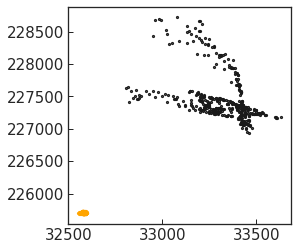

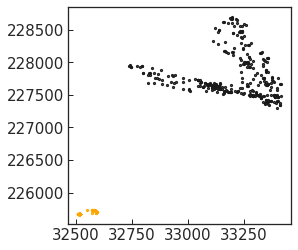

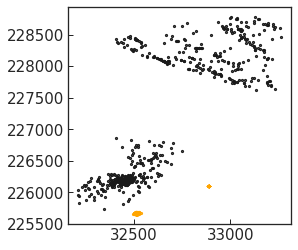

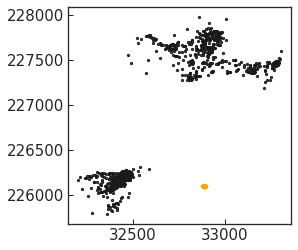

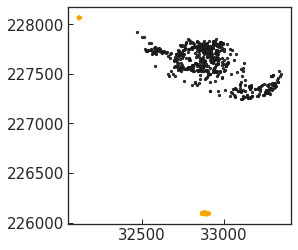

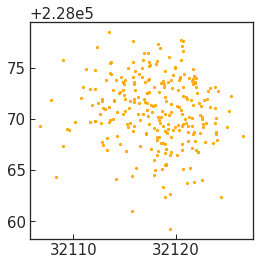

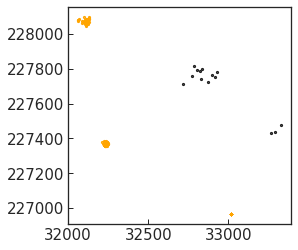

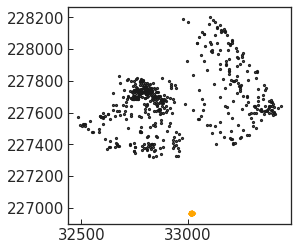

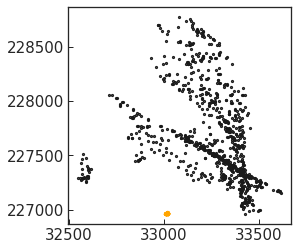

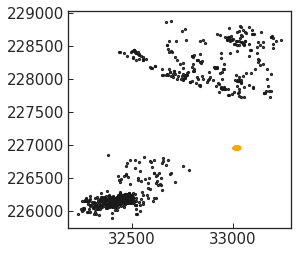

In [44]:
for sidx in range(400,410):
    mask4 = sidx4==sidx
    mask1 = sidx1==sidx
    
    fig = plt.figure(figsize=(4,4))
    plt.scatter(pos1[mask1,0],pos1[mask1,1],s=1,color='k') 
    plt.scatter(pos4[mask4,0],pos4[mask4,1],s=1,color='orange') 
    plt.show()
    